In [37]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '5,6'
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5,6"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [38]:
# Using seaborn for pairplot.
!pip install -q seaborn
!pip install -q tensorflow

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [40]:
# Load the CSV file
df = pd.read_csv('Next_Generation_Simulation__NGSIM__Vehicle_Trajectories_and_Supporting_Data_20240819.csv')

# Select the required columns
required_columns = ['Global_X', 'Global_Y', 'v_Vel', 'v_Acc', 'Global_Time', 'Vehicle_ID']
velocity_dataset = df[required_columns]

In [41]:
velocity_dataset.shape

(9455901, 6)

In [42]:
# Sort by Vehicle_ID and Global_Time
velocity_dataset_sorted = velocity_dataset.sort_values(by=['Vehicle_ID', 'Global_Time']).reset_index(drop=True)

# Filter data for a specific vehicle ID
specific_vehicle_id = 396
single_vehicle_data = velocity_dataset_sorted[velocity_dataset_sorted['Vehicle_ID'] == specific_vehicle_id]

In [71]:
velocity_dataset_sorted

,Global_X,Global_Y,v_Vel,v_Acc,Global_Time,Vehicle_ID
0,6042841.908,2133120.155,12.50,0.00,1113433136300,1
1,6042839.670,2133135.799,14.64,0.08,1113433137500,1
2,6042839.214,2133138.665,14.59,-0.54,1113433137700,1
3,6042838.525,2133142.971,14.13,-3.49,1113433138000,1
4,6042837.417,2133153.456,13.00,0.00,1113433138800,1
...,...,...,...,...,...,...
9455896,6042608.928,2134671.977,63.93,-11.20,1113433457400,3366
9455897,6042607.952,2134678.398,62.22,-11.20,1113433457500,3366
9455898,6042606.994,2134684.573,62.22,0.00,1113433457600,3366
9455899,6042606.083,2134690.504,62.22,0.00,1113433457700,3366


In [72]:
# Extract the velocity column
velocities = single_vehicle_data['v_Vel'].values

In [73]:
# Function to convert a series to a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    df_s = pd.DataFrame(data)
    cols, names = [], []
    
    # Input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df_s.shift(i))
        names.append(f'var1(t-{i})')
    
    # Forecast sequence (t)
    for i in range(0, n_out):
        cols.append(df_s.shift(-i))
        names.append(f'var1(t+{i})')
    
    # Combine all
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [74]:
# Convert to supervised learning problem
n_in = 8  # Number of previous time steps as input
n_out = 1  # Predict one step ahead
supervised_data = series_to_supervised(velocities, n_in=n_in, n_out=n_out)

# Split into train, validation, and test sets
n_train = int(len(supervised_data) * 0.7)
n_validation = int(len(supervised_data) * 0.15)

train_data = supervised_data[:n_train]
validation_data = supervised_data[n_train:n_train + n_validation]
test_data = supervised_data[n_train + n_validation:]

In [75]:
# Separate inputs (X) and outputs (y)
X_train, y_train = train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values
X_validation, y_validation = validation_data.iloc[:, :-1].values, validation_data.iloc[:, -1].values
X_test, y_test = test_data.iloc[:, :-1].values, test_data.iloc[:, -1].values

# Reshape data for transformer (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], n_in, 1))
X_validation = X_validation.reshape((X_validation.shape[0], n_in, 1))
X_test = X_test.reshape((X_test.shape[0], n_in, 1))

In [76]:
print(X_test.shape)
print(y_test.shape)

(1246, 8, 1)
(1246,)


In [77]:
# Define transformer encoder block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-head attention
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed-forward network
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [78]:
# Build the transformer model
def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0.1, mlp_dropout=0.1):
    inputs = layers.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D()(x)
    for units in mlp_units:
        x = layers.Dense(units, activation='relu')(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return models.Model(inputs, outputs)

In [79]:
# Define model parameters
input_shape = (n_in, 1)

transformer_model = build_transformer_model(
    input_shape=input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    dropout=0.2,
    mlp_dropout=0.2
)

transformer_model.compile(optimizer='adam', loss='mse')
transformer_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 8, 1)]               0         []                            
                                                                                                  
 multi_head_attention_28 (M  (None, 8, 1)                 7169      ['input_8[0][0]',             
 ultiHeadAttention)                                                  'input_8[0][0]']             
                                                                                                  
 dropout_63 (Dropout)        (None, 8, 1)                 0         ['multi_head_attention_28[0][0
                                                                    ]']                           
                                                                                            

 dropout_68 (Dropout)        (None, 8, 4)                 0         ['conv1d_60[0][0]']           
                                                                                                  
 conv1d_61 (Conv1D)          (None, 8, 1)                 5         ['dropout_68[0][0]']          
                                                                                                  
 layer_normalization_61 (La  (None, 8, 1)                 2         ['conv1d_61[0][0]']           
 yerNormalization)                                                                                
                                                                                                  
 tf.__operators__.add_61 (T  (None, 8, 1)                 0         ['layer_normalization_61[0][0]
 FOpLambda)                                                         ',                            
                                                                     'tf.__operators__.add_60[0][0
          

In [80]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = transformer_model.fit(
    X_train, y_train,
    validation_data=(X_validation, y_validation),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss = transformer_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")

# Compute RMSE
rmse = np.sqrt(test_loss)
print(f"Test RMSE: {rmse:.4f}")

Epoch 1/50
182/182 [==============================] - 16s 22ms/step - loss: 140.5776 - val_loss: 6.4532
Epoch 2/50
182/182 [==============================] - 4s 21ms/step - loss: 68.0083 - val_loss: 7.3835
Epoch 3/50
182/182 [==============================] - 4s 22ms/step - loss: 68.5328 - val_loss: 6.5350
Epoch 4/50
182/182 [==============================] - 4s 21ms/step - loss: 67.5727 - val_loss: 6.1581
Epoch 5/50
182/182 [==============================] - 4s 20ms/step - loss: 67.0235 - val_loss: 6.1508
Epoch 6/50
182/182 [==============================] - 3s 18ms/step - loss: 66.6938 - val_loss: 7.4312
Epoch 7/50
182/182 [==============================] - 3s 19ms/step - loss: 67.2310 - val_loss: 5.9141
Epoch 8/50
182/182 [==============================] - 4s 22ms/step - loss: 66.2978 - val_loss: 5.9645
Epoch 9/50
182/182 [==============================] - 5s 27ms/step - loss: 66.3600 - val_loss: 6.2802
Epoch 10/50
182/182 [==============================] - 5s 28ms/step - loss: 65.2

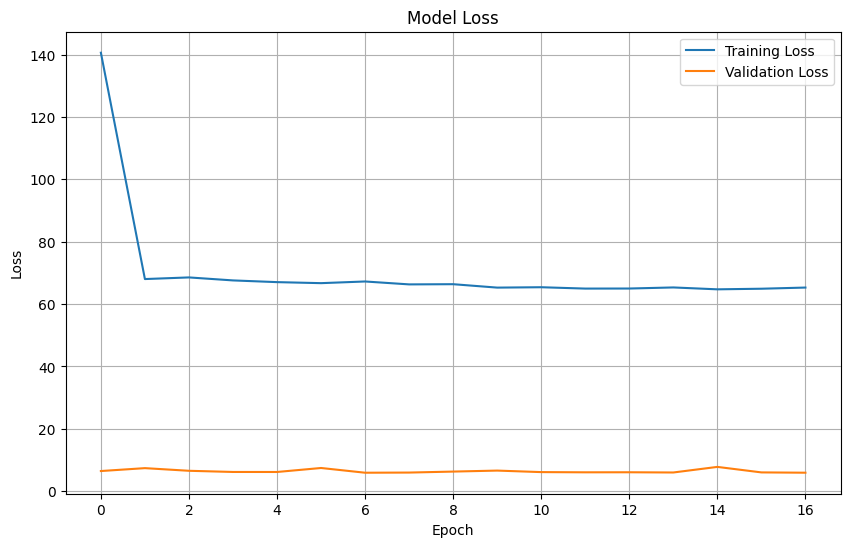

In [81]:
# Plotting training & validation loss curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history.get('val_loss'), label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [82]:
# Iterative prediction using transformer model
X_test_iterative = X_test.copy()  # Copy test data to avoid modifying original
iterative_predictions = []

# Perform iterative predictions
for i in range(len(X_test_iterative)):
    # Extract current sequence and reshape for prediction
    current_sequence = X_test_iterative[i].reshape(1, n_in, 1)  # Shape: (1, n_in, 1)
    
    # Debugging print statements
    print(f"i = {i}, current_sequence shape = {current_sequence.shape}")
    
    # Predict the next velocity
    predicted_velocity = transformer_model.predict(current_sequence, verbose=0).flatten()[0]
    
    # Append the predicted velocity
    iterative_predictions.append(predicted_velocity)
    
    # Update the input sequence for the next prediction
    if i < len(X_test_iterative) - 1:  # Avoid index out of bounds
        # Shift the sequence to the left
        X_test_iterative[i + 1, :-1, 0] = X_test_iterative[i + 1, 1:, 0]
        # Replace the last value with the predicted velocity
        X_test_iterative[i + 1, -1, 0] = predicted_velocity

# Print the predicted velocities for the test dataset
print("Predicted velocities for the test dataset are:", iterative_predictions)
print(len(iterative_predictions))

i = 0, current_sequence shape = (1, 8, 1)
i = 1, current_sequence shape = (1, 8, 1)
i = 2, current_sequence shape = (1, 8, 1)
i = 3, current_sequence shape = (1, 8, 1)
i = 4, current_sequence shape = (1, 8, 1)
i = 5, current_sequence shape = (1, 8, 1)
i = 6, current_sequence shape = (1, 8, 1)
i = 7, current_sequence shape = (1, 8, 1)
i = 8, current_sequence shape = (1, 8, 1)
i = 9, current_sequence shape = (1, 8, 1)
i = 10, current_sequence shape = (1, 8, 1)
i = 11, current_sequence shape = (1, 8, 1)
i = 12, current_sequence shape = (1, 8, 1)
i = 13, current_sequence shape = (1, 8, 1)
i = 14, current_sequence shape = (1, 8, 1)
i = 15, current_sequence shape = (1, 8, 1)
i = 16, current_sequence shape = (1, 8, 1)
i = 17, current_sequence shape = (1, 8, 1)
i = 18, current_sequence shape = (1, 8, 1)
i = 19, current_sequence shape = (1, 8, 1)
i = 20, current_sequence shape = (1, 8, 1)
i = 21, current_sequence shape = (1, 8, 1)
i = 22, current_sequence shape = (1, 8, 1)
i = 23, current_seque

i = 191, current_sequence shape = (1, 8, 1)
i = 192, current_sequence shape = (1, 8, 1)
i = 193, current_sequence shape = (1, 8, 1)
i = 194, current_sequence shape = (1, 8, 1)
i = 195, current_sequence shape = (1, 8, 1)
i = 196, current_sequence shape = (1, 8, 1)
i = 197, current_sequence shape = (1, 8, 1)
i = 198, current_sequence shape = (1, 8, 1)
i = 199, current_sequence shape = (1, 8, 1)
i = 200, current_sequence shape = (1, 8, 1)
i = 201, current_sequence shape = (1, 8, 1)
i = 202, current_sequence shape = (1, 8, 1)
i = 203, current_sequence shape = (1, 8, 1)
i = 204, current_sequence shape = (1, 8, 1)
i = 205, current_sequence shape = (1, 8, 1)
i = 206, current_sequence shape = (1, 8, 1)
i = 207, current_sequence shape = (1, 8, 1)
i = 208, current_sequence shape = (1, 8, 1)
i = 209, current_sequence shape = (1, 8, 1)
i = 210, current_sequence shape = (1, 8, 1)
i = 211, current_sequence shape = (1, 8, 1)
i = 212, current_sequence shape = (1, 8, 1)
i = 213, current_sequence shape 

i = 379, current_sequence shape = (1, 8, 1)
i = 380, current_sequence shape = (1, 8, 1)
i = 381, current_sequence shape = (1, 8, 1)
i = 382, current_sequence shape = (1, 8, 1)
i = 383, current_sequence shape = (1, 8, 1)
i = 384, current_sequence shape = (1, 8, 1)
i = 385, current_sequence shape = (1, 8, 1)
i = 386, current_sequence shape = (1, 8, 1)
i = 387, current_sequence shape = (1, 8, 1)
i = 388, current_sequence shape = (1, 8, 1)
i = 389, current_sequence shape = (1, 8, 1)
i = 390, current_sequence shape = (1, 8, 1)
i = 391, current_sequence shape = (1, 8, 1)
i = 392, current_sequence shape = (1, 8, 1)
i = 393, current_sequence shape = (1, 8, 1)
i = 394, current_sequence shape = (1, 8, 1)
i = 395, current_sequence shape = (1, 8, 1)
i = 396, current_sequence shape = (1, 8, 1)
i = 397, current_sequence shape = (1, 8, 1)
i = 398, current_sequence shape = (1, 8, 1)
i = 399, current_sequence shape = (1, 8, 1)
i = 400, current_sequence shape = (1, 8, 1)
i = 401, current_sequence shape 

i = 567, current_sequence shape = (1, 8, 1)
i = 568, current_sequence shape = (1, 8, 1)
i = 569, current_sequence shape = (1, 8, 1)
i = 570, current_sequence shape = (1, 8, 1)
i = 571, current_sequence shape = (1, 8, 1)
i = 572, current_sequence shape = (1, 8, 1)
i = 573, current_sequence shape = (1, 8, 1)
i = 574, current_sequence shape = (1, 8, 1)
i = 575, current_sequence shape = (1, 8, 1)
i = 576, current_sequence shape = (1, 8, 1)
i = 577, current_sequence shape = (1, 8, 1)
i = 578, current_sequence shape = (1, 8, 1)
i = 579, current_sequence shape = (1, 8, 1)
i = 580, current_sequence shape = (1, 8, 1)
i = 581, current_sequence shape = (1, 8, 1)
i = 582, current_sequence shape = (1, 8, 1)
i = 583, current_sequence shape = (1, 8, 1)
i = 584, current_sequence shape = (1, 8, 1)
i = 585, current_sequence shape = (1, 8, 1)
i = 586, current_sequence shape = (1, 8, 1)
i = 587, current_sequence shape = (1, 8, 1)
i = 588, current_sequence shape = (1, 8, 1)
i = 589, current_sequence shape 

i = 756, current_sequence shape = (1, 8, 1)
i = 757, current_sequence shape = (1, 8, 1)
i = 758, current_sequence shape = (1, 8, 1)
i = 759, current_sequence shape = (1, 8, 1)
i = 760, current_sequence shape = (1, 8, 1)
i = 761, current_sequence shape = (1, 8, 1)
i = 762, current_sequence shape = (1, 8, 1)
i = 763, current_sequence shape = (1, 8, 1)
i = 764, current_sequence shape = (1, 8, 1)
i = 765, current_sequence shape = (1, 8, 1)
i = 766, current_sequence shape = (1, 8, 1)
i = 767, current_sequence shape = (1, 8, 1)
i = 768, current_sequence shape = (1, 8, 1)
i = 769, current_sequence shape = (1, 8, 1)
i = 770, current_sequence shape = (1, 8, 1)
i = 771, current_sequence shape = (1, 8, 1)
i = 772, current_sequence shape = (1, 8, 1)
i = 773, current_sequence shape = (1, 8, 1)
i = 774, current_sequence shape = (1, 8, 1)
i = 775, current_sequence shape = (1, 8, 1)
i = 776, current_sequence shape = (1, 8, 1)
i = 777, current_sequence shape = (1, 8, 1)
i = 778, current_sequence shape 

i = 944, current_sequence shape = (1, 8, 1)
i = 945, current_sequence shape = (1, 8, 1)
i = 946, current_sequence shape = (1, 8, 1)
i = 947, current_sequence shape = (1, 8, 1)
i = 948, current_sequence shape = (1, 8, 1)
i = 949, current_sequence shape = (1, 8, 1)
i = 950, current_sequence shape = (1, 8, 1)
i = 951, current_sequence shape = (1, 8, 1)
i = 952, current_sequence shape = (1, 8, 1)
i = 953, current_sequence shape = (1, 8, 1)
i = 954, current_sequence shape = (1, 8, 1)
i = 955, current_sequence shape = (1, 8, 1)
i = 956, current_sequence shape = (1, 8, 1)
i = 957, current_sequence shape = (1, 8, 1)
i = 958, current_sequence shape = (1, 8, 1)
i = 959, current_sequence shape = (1, 8, 1)
i = 960, current_sequence shape = (1, 8, 1)
i = 961, current_sequence shape = (1, 8, 1)
i = 962, current_sequence shape = (1, 8, 1)
i = 963, current_sequence shape = (1, 8, 1)
i = 964, current_sequence shape = (1, 8, 1)
i = 965, current_sequence shape = (1, 8, 1)
i = 966, current_sequence shape 

i = 1128, current_sequence shape = (1, 8, 1)
i = 1129, current_sequence shape = (1, 8, 1)
i = 1130, current_sequence shape = (1, 8, 1)
i = 1131, current_sequence shape = (1, 8, 1)
i = 1132, current_sequence shape = (1, 8, 1)
i = 1133, current_sequence shape = (1, 8, 1)
i = 1134, current_sequence shape = (1, 8, 1)
i = 1135, current_sequence shape = (1, 8, 1)
i = 1136, current_sequence shape = (1, 8, 1)
i = 1137, current_sequence shape = (1, 8, 1)
i = 1138, current_sequence shape = (1, 8, 1)
i = 1139, current_sequence shape = (1, 8, 1)
i = 1140, current_sequence shape = (1, 8, 1)
i = 1141, current_sequence shape = (1, 8, 1)
i = 1142, current_sequence shape = (1, 8, 1)
i = 1143, current_sequence shape = (1, 8, 1)
i = 1144, current_sequence shape = (1, 8, 1)
i = 1145, current_sequence shape = (1, 8, 1)
i = 1146, current_sequence shape = (1, 8, 1)
i = 1147, current_sequence shape = (1, 8, 1)
i = 1148, current_sequence shape = (1, 8, 1)
i = 1149, current_sequence shape = (1, 8, 1)
i = 1150, 

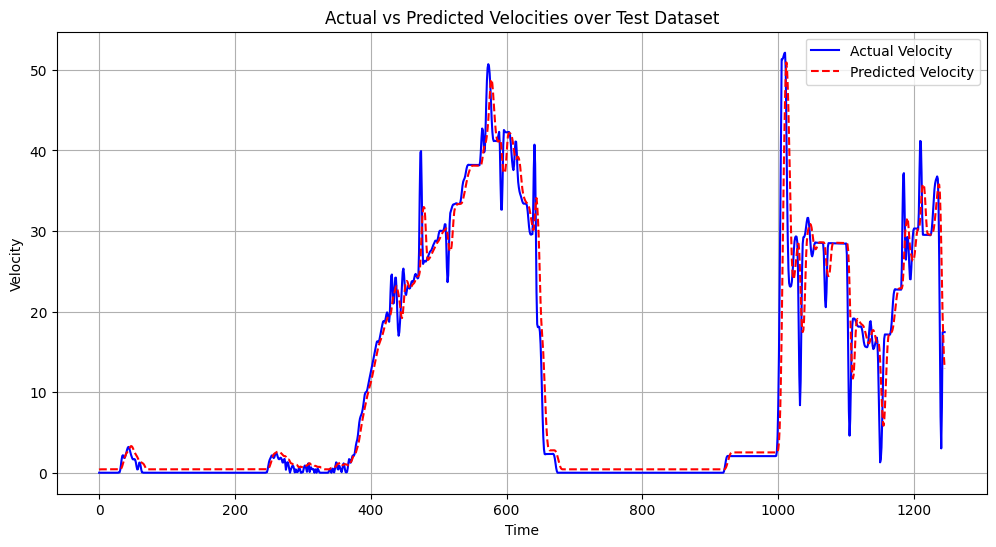

In [83]:
# Create time indices for the test dataset
time_indices = np.arange(len(y_test))  # Sequential time indices for true values

# Create a DataFrame to align actual and predicted velocities with time
results_df = pd.DataFrame({
    'Time': time_indices,
    'Actual Velocity': y_test,
    'Predicted Velocity': iterative_predictions
})

# Plot the actual vs predicted velocities
plt.figure(figsize=(12, 6))

# Plot actual velocities
plt.plot(results_df['Time'], results_df['Actual Velocity'], label='Actual Velocity', color='blue')

# Plot predicted velocities
plt.plot(results_df['Time'], results_df['Predicted Velocity'], label='Predicted Velocity', color='red', linestyle='--')

# Add labels, title, and grid
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Actual vs Predicted Velocities over Test Dataset')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()